# DARHT Axis-II Dispenser-Cathode

- Analysis for 2021 Weapons Engineering Symposium and Journal
  - DARHT Axis-II Dispenser-Cathode Emissivity and Temperature
      - LA-UR-21-25647 (paper)
      - LA-UR-21-28231 (presentation) 
- Jason Koglin, Los Alamos National Laboratory
- koglin@lanl.gov

## Abstract
Abstract— For more than a decade the Dual-Axis Radiographic Hydrodynamic Test (DARHT) facility has been executing flash radiography for large hydrodynamic experiments at the Los Alamos National Laboratory (LANL). A hot dispenser cathode is used to supply electrons for the second DARHT axis. A consistent measurement of the cathode surface temperature over long periods of time is critical to maintaining optimal cathode performance while maximizing the effective working lifetime of the cathode. We report on a temperature and emissivity model that has been developed and applied to data from diagnostics used to measure the surface temperature of the DARHT Axis-II hot dispenser cathode over more than a decade of operation.

Note that small differences between the results here and those in the paper are due to some updates in the codes after a new FMP2 pyrometer was deployed in 2021 after the paper was originally written.

## License
This analysis is part of the catemis package, 
which is distributed as open-source software under a BSD 3-Clause License

© 2022. Triad National Security, LLC. All rights reserved.
LANL Copyright No. C21111.

This program was produced under U.S. Government contract 89233218CNA000001 for Los Alamos
National Laboratory (LANL), which is operated by Triad National Security, LLC for the U.S.
Department of Energy/National Nuclear Security Administration. All rights in the program are
reserved by Triad National Security, LLC, and the U.S. Department of Energy/National Nuclear
Security Administration. The Government is granted for itself and others acting on its behalf a
nonexclusive, paid-up, irrevocable worldwide license in this material to reproduce, prepare
derivative works, distribute copies to the public, perform publicly and display publicly, and to permit
others to do so.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its contributors
   may be used to endorse or promote products derived from this software
   without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" 
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE 
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE 
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE 
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

## Introduction
- The penetrating radiography provided by DARHT is a key capability in executing a core mission of LANL.  
- DARHT consists of two Linear Induction Accelerators (LIAs).  
- The DARHT Axis-II LIA relies on a 6.5” diameter hot, dispenser cathode to supply electrons to generate a 1.7 kA, 16.5 MeV long electron pulse.  Multiple short pulses are extracted from the 1.6 $\mu$s long Axis-II pulse using a kicker downstream of the LIA, focused onto a target and converted to bremsstrahlung radiation.


## DARHT Axis-II Cathode

The cathode used on DARHT Axis-II is identified as 311X-M and fabricated by HeatWave Labs, Inc.  
- The planar cathode is composed of sintered Tungsten impregnated with a mixture of Barium Oxide, Calcium Oxide and Aluminate with a molar ratio of 3:1:1, doped with scandium and coated with ~0.5 um of Os-Ru.  
- The cathode is 6.5” in diameter with a single heating coil ring at 4.4” diameter.  
- The current emitted by the cathode increases with temperature up to a point where the current density is space-charge limited.  


Since it is desirable to operate with a uniform current density, the power supplied to the heating coil must be sufficient to heat the entire cathode surface in order to maintain a minimum temperature, and thus space-charge limited emission, over the entire cathode surface.  
- The effective cathode lifetime is limited by the availability of Barium, which evaporates over time exponentially with temperature.  
- The DARHT 2 kA Cathode Development report (Bieniosek, F.M., et al., DARHT 2 kA Cathode Development. 2009) provides further details on the cathode properties.  
- The appropriate operating temperature is determined experimentally by measuring the extracted charge versus operating temperature.  
- Since these experiments are challenging to conduct, a consistent and stable measurement of the cathode surface temperature is needed for optimal cathode operation.  

For the DARHT Axis-II cathode, three spot pyrometers are used to measure the temperature of the cathode and a camera is used to monitor the uniformity of the cathode as illustrated in Figure 1.


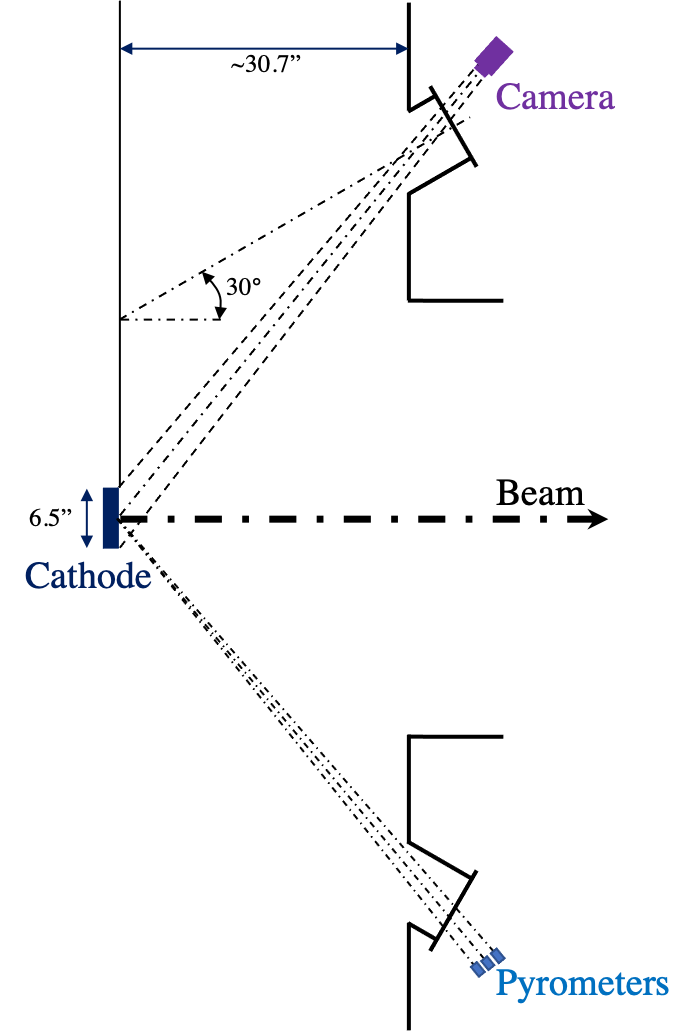

Figure 1:  Side view of the DARHT Axis-II cathode including pyrometers and cathode camera. Two FAR pyrometers, as well as the Omega pyrometer, view the cathode surface through a viewport from below at an angle of about 51 degrees with respect to the normal at a distance of nearly 2 meters. The cathode (CAT) camera has a similar view of the cathode from a port above.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labelsfont
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

import numpy as np
import pandas as pd
import xarray as xr

from pathlib import Path

In [ ]:
import catemis
from catemis import planck, cathode, far_pyro
print('catemis version', catemis.__version__)

### Configuration Parameters

In [ ]:
# Day in yyyymmdd format
daystr = '20200701'
# Use complete = True keyword since data was taken without shot numbers used in accelerator operations. 
complete = True
# Some shots were repeats -- only use shots after cathode had settled for the primary power settings
shots = [1,3,8,9,10,11,13,14,15]
# Format daystr into a date string
datestr = '{:}-{:}-{:}'.format(daystr[0:4], daystr[4:6], daystr[6:8])

In [ ]:
# nroll is the number of controls points to average over (controls data recorded every 30 sec)
nroll = 7
# cat_radiated parameter for fraction of power radiated used in Equation 11
cat_radiated = 0.617
# Omega correction factors used in Equation 8
fTo=32
fTc=20000
# Cathode camera calibration factor
calfactor=2.85e-15

# emissivity function factors
aparam=0.35 
bparam=0.24

In [ ]:
cat_params = {
        'desc': 'New cathode camera',
        'shot_null': 1,
        'daystr_null': '20190314',
        'ry': 53,
        'rx': -11,
        'y0': 630,
        'x0': 550,
        'dcat': 490,
        'orientation': 0,
        'focal': 100,
        'rcat': 6.5/2*25.4, # 6.5 inch diameter
        'Zcam': (30.7+10)*25.4,
        'psize': 0.00375,
    }

In [ ]:
# pyrometer parameters for two-band temperature calculation
fmp1_twoband_pars = [ 108.1, -245.2,  987.3,  256.1]
fmp2_twoband_pars = [367.8, 321.0]

In [ ]:
# FMP1 FAR pyrometer calibration data
dcrx1 = far_pyro.load_far_crx('FMP1.crx')
dcrx1

In [ ]:
# FMP2 FAR pyrometer calibration data
dcrx2 = far_pyro.load_far_crx('FMP2.crx')
dcrx2

In [ ]:
# Planck fit masks for FMP1
dwave_fit1 = far_pyro.load_wave_fit('FMP1_mask.csv')
dwave_fit1

In [ ]:
# Planck fit masks for FMP1
dwave_fit2 = far_pyro.load_wave_fit('FMP2_mask.csv')
dwave_fit2

### Emissivity Model Load Method

In [ ]:
dsb = cathode.load_emissivity(aparam=aparam, bparam=bparam)
emissivity = dsb.emissivity
emissivity

### Load Data Methods    

In [ ]:
# Load Cathode Camera Data
from catemis import cathode
ds = cathode.load_cathode(daystr, **cat_params)



In [ ]:
# Add time in hours for the day
ahours = [dval.hour+dval.minute/60+dval.second/60**2 
          for dval in ds.datetime.to_pandas()]
ds.coords['hours'] = (('shot'), ahours)

In [ ]:
ds.datetime.to_pandas()

In [ ]:
# Load FMP1 data
ds1 = far_pyro.load_pyro(pyro='FMP1', daystr=daystr)
ds1 = far_pyro.pyro_temperature_twoband(ds1, twoband_pars=fmp1_twoband_pars)
ds1 = far_pyro.add_ramp_flags(ds1)
ds1

In [ ]:
# Load FMP2 data
ds2 = far_pyro.load_pyro(pyro='FMP2', daystr=daystr)
ds2 = far_pyro.pyro_temperature_twoband(ds2, twoband_pars=fmp2_twoband_pars)
ds2 = far_pyro.add_ramp_flags(ds2)

# Make time correction to FMP2 data because absolute computer time is not reliable
ds2 = far_pyro._correct_fmp2_time_with_fmp1(ds2,ds1)
ds2

In [ ]:
# Add relevant pyrometer data for DAAAC cathode shots with pyro name prepended to pyrometer data_vars and coords

# Need dcalib, wave_fit and emissivity to pass to far_pyro.far_temperature for Planck fit
ds = cathode.add_pyro_data(ds, ds1, 
        dcalib=dcrx1.dcalib,
        wave_fit=dwave_fit1.wave_fit,
        emissivity=emissivity,
    )
ds = cathode.add_pyro_data(ds, ds2, 
        dcalib=dcrx2.dcalib,
        wave_fit=dwave_fit2.wave_fit,
        emissivity=emissivity,
    )
ds

## Planck Spectral Radiance

The DARHT data acquisition system, DAAAC, was used to capture the cathode camera image at each power setting.   The cathode controls settings, which are detailed in Table 2, were retrieved from controls information logs.  While the power radiated by the cathode is primarily a function of temperature, the emissivity is not constant with wavelength so it cannot be treated simplistically with the Stefan-Boltzmann equation, which is only a function of temperature.  Instead, the spectral radiance, shown for several example temperatures in Figure 2, must be convolved with the emissivity model defined in Equation 9 and shown in Figure 3.

- The blackbody spectral radiance vs wavelength over a range of temperatures relevant for the FAR pyrometers is plotted in Figure 2. 
- The high and low Omega IR2C pyrometer bands are also show in Figure 2 as dashed arrows. 
- The spectral radiance is defined by the Planck equation

$W(T,\lambda) = \frac{2hc}{\lambda^5 \left(\exp \left(\frac{hc}{\lambda kT} \right) -1 \right)}$

In [ ]:
fig,axes = plt.subplots(1,1, figsize=[5,5])
ax = axes

tempvals = [1400,1300,1200,1100,1000,900,800,700,600]
dsbt = dsb.planck_pdf.sel(temperature=tempvals)
lines = dsbt.plot(hue='temperature', ax=ax, add_legend=False)
ax.set_xlim(200,2000)
ax.set_ylim(0,6.5e10)
ax.legend(lines, tempvals, title='Temperature [C]', 
           bbox_to_anchor=(1.05, 1), 
           fontsize='small', title_fontsize='small', loc='upper left', 
         )

prect2 = [mpatches.Rectangle((453.8,0),966.1-453.8,6.5e10, ec="none")]
pcoll2 = PatchCollection(prect2, facecolor='r', alpha=0.25, edgecolor=None)
ax.add_collection(pcoll2)
ax.text(560, 6.e10, 'FMP2', {'ha':'left'})
prect1 = [mpatches.Rectangle((857.3,0),1636.3-857.3,6.5e10, ec="none")]
pcoll1 = PatchCollection(prect1, facecolor='b', alpha=0.25, edgecolor=None)
ax.add_collection(pcoll1)
ax.text(1100, 6.e10, 'FMP1', {'ha':'left'})

ax.annotate("Omega Low", xy=(400, 4.8e10))
ax.annotate("", xy=(400,4.5e10), xytext=(1000, 4.5e10), 
            arrowprops=dict(arrowstyle='<->', linestyle = '--', ))

ax.annotate("Omega High", xy=(1000, 5.4e10))
ax.annotate("", xy=(1000,5.1e10), xytext=(1600, 5.1e10), 
            arrowprops=dict(arrowstyle='<->', linestyle = '--', ))

Figure 2:  Blackbody spectral radiance vs wavelength for a range of temperatures relevant for the FMP1 and FMP2 FAR pyrometers. The wavelength ranges for the FMP1 and FMP2 pyrometers are highlighted in blue and red, respectively

## Cathode Emissivity Model
- Sepctroradiometer @ 25C data from Simmons LAUR-04-8599 
- Equation 9:  The emissivity model is defined as the emissivity at 25 ℃ with an offset and scale factor,
  
$\epsilon\left(\lambda\right) = \alpha_\epsilon \epsilon_o \left( \lambda \right) + b_\epsilon$ 

- The factors $a_\epsilon = 0.35$ and $b_\epsilon = 0.24$ provide good
agreement with measurements from all four diagnostics over the range of
temperatures for which the cathode is operated. 
- The emissivity function $\epsilon(\lambda)$ is shown as the solid green line in Figure 3 along with the spectroradiometer emissivity $\epsilon_o$ (dashed black line). 
- The spectral ranges of the FMP1 and FMP2 pyrometers are indicated by the blue and red shaded regions, respectively. 
- The high and low ranges of the Omega pyrometer are similar to the FMP1 and FMP2 ranges, respectively.
- The monochrome cathode camera operates in the range of the FMP2 pyrometer

In [ ]:
fig,ax = plt.subplots(1,1, figsize=[8,6])
(dsb.emissivity*100).plot(ax=ax, linewidth=5,
                     label='Emissivity Model', color='g')

(dsb.emissivity0*100).plot(ax=ax, linestyle='--', linewidth=5,
                      label='Spectroradiometer @ 25 C', color='k')

ax.set_ylim(25,75)
ax.set_xlim(0,2500)
ax.set_ylabel('Emissivity [%]')
ax.legend()

prect2 = [mpatches.Rectangle((453.8,0),966.1-453.8,100, ec="none")]
pcoll2 = PatchCollection(prect2, facecolor='r', alpha=0.25, edgecolor=None)
ax.add_collection(pcoll2)
ax.text(560, 35, 'FMP2', {'ha':'left'})
prect1 = [mpatches.Rectangle((857.3,0),1636.3-857.3,100, ec="none")]
pcoll1 = PatchCollection(prect1, facecolor='b', alpha=0.25, edgecolor=None)
ax.add_collection(pcoll1)
ax.text(1200, 35, 'FMP1', {'ha':'left'})

plt.grid()
plt.suptitle('Emissivity Model of the 6.5-Inch Cathode')
plt.tight_layout(rect=[0, 0.03, 1, 1])

Figure 3: Cathode emissivity model (green) based on empirical model that involves weighting the measured emissivity at 25 ℃ (black dashed) with a constant emissivity value that results in spectra that are consistent over a range of temperatures within both the FMP1 (blue) and FMP2 (red) wavelength ranges.

## Cathode Camera 

- The cathode camera views the cathode from above at an angle of 51 degrees.
- The current camera in use is a Mako G-125B Gig-E monochrome camera, a Type 1/3 CCD camera with a 1292 x 964 array of 3.75 um pixels, which is produced by Allied Vision.

### Cathode Camera QE and Cathode Emissivity 

- The quantum efficiency (Q.E.) of the Mako G-125B CCD camera is plotted versus wavelength in Figure 12 along with the emissivity model from Equation 9.

In [ ]:
# Calculate cathode temperature
ds = cathode.calculate_catcam_temperature(ds, calfactor=calfactor) 

In [ ]:
df = cathode.read_camera_response()
tempvals = [1200,1150,1100,1050,1000,950,900,850]

fig,axes = plt.subplots(1,1, figsize=[7,6])
ax = axes
(df['M']*100).plot(color='k', linestyle='--', ax=ax, label='QE')
(ds.CatCam_emissivity*100).plot(linestyle='-.', ax=ax, label='Emissivity', color='r')
(ds.CatCam_emissivity*ds['QE_mono']*100).plot(ax=ax, label='QE x Emissivity', color='b')

ax2 = ax.twinx()
dplks = ds.CatCam_planck_pdf.sel(temperature=tempvals).sel(temperature=tempvals)
lines= dplks.plot(hue='temperature', ax=ax2)

ax.legend(bbox_to_anchor=(0.54, 0.45))
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Camera QE and Emissivity [%]')
ax.set_xlim(350,1150)
ax.set_ylim(0,75)

ax2.set_yscale('log')
ax2.set_ylim(1e4,1e10)
ax2.legend(lines, tempvals, title='Temperature [C]', 
           bbox_to_anchor=(1.25, 0.9), 
           loc='upper left', 
         )

Figure 12: Cathode camera response and cathode emissivity, as well as the
blackbody power distribution, are plotted on right vs wavelength in units of nm.
A model of cathode intensity vs temperature plotted on right along with FMP1 and
FMP2 temperature measurements and mean cathode temperature based on the
emissivity model.

### Cathode Raw Images

- Series of shots recorded in DAAAC for cathode camera only 2021-07-01

In [ ]:
dar = cathode.load_catcams(daystr, complete=complete, raw=True)
dars = dar.sel(shot=shots)

rect = [0, 0.03, 0.85, 1.]
aspect = rect[3]-rect[1]
col_wrap = 3

dars.plot(x='CAT_Xind', y='CAT_Yind', col='shot', 
          aspect=aspect, col_wrap=col_wrap, 
          robust=True, clim=[0,1000])
plt.suptitle('Raw Cathode Images {:}'.format(datestr), y=1.03)

Figure 13 (left): Raw cathode camera images for 2020-07-01 measurements at nine different cathode power settings.

### Cathode Aspect Corrected
- The Cathode is viewed from above at a ~50 degree angle with the camera horizontally offset from the beam axis by ~10 degrees.
- The Cathode camera image is transformed using the skimage.transform.warp method based on Euler angles using a rotation matrix generated with the scipy.spatial.transform.Rotation.from_euler method
- The camera pixel intensities are corrected inversely with the square of the relative distance from a position on the cathode to the camera focal plane using these same transformations. 
- With an effective camera acceptance factor of 2.814e-15 per pixel (i.e., photon to ADU conversion factor), and assuming the same emissivity model used for the pyrometer temperature calculations, the temperature calculated from the mean cathode intensity agrees extremely well with both the FMP1 and FMP2 measurements as well as the model based only on the corrected cathode power and emissivity.

In [ ]:
dcats = ds.CatCam.where(ds.CatCut).where(ds.CatCam>0).sel(shot=shots)
dcats.plot(col='shot', col_wrap=3, aspect=aspect, robust=True, clim=[0,1000])
plt.suptitle('Cathode Corrected {:}'.format(datestr), y=1.03)

Figure 13 (right): The camera is rotated by 90 degrees so that the vertical plane of the cathode is plotted along the horizontal axis. Aspect corrected cathode camera images.

### Cathode Camera Temperature Calibration
- cathode camera integration 80 msec: 
    catcam_integration = 0.080 
- calibration factor: 
    calfactor = 2.815e-15

In [ ]:
# Calculate cathode temperature (previously calculated for making Fig 12)
ds.coords['CatTemp_center'] = ds.CatTemp.where(ds.CAT_R<25.4/2) \
                              .mean(dim=['CAT_X','CAT_Y'])

In [ ]:
dcats = ds.CatTemp.where(ds.CatCut).sel(shot=shots)
dcats.plot(col='shot', col_wrap=3, aspect=aspect, robust=True)
plt.suptitle('Cathode Corrected {:}'.format(datestr), y=1.03)

Additional Figure not used in paper showing calibrated temperature distributions for the 9 shots used in the paper.

In [ ]:
das = (ds.CatTemp.where(ds.CatCut)-ds.FMP1_planck_temp).sel(shot=shots)
das.attrs['long_name'] = 'Cathode Temperature Uniformity'
das.attrs['units'] = 'C'
das['dT'] = das.FMP1_planck_temp - das.FMP1_planck_temp[0]
das.swap_dims({'shot':'dT'}).plot(col='dT',col_wrap=col_wrap, clim=[-12,12], robust=True)
plt.suptitle('Cathode Uniformity {:} ($T_o$ = {:} C)'
             .format(datestr, int(das.FMP1_planck_temp[0])), y=1.03)
#plt.tight_layout(rect=rect)

Figure 5: Calculated cathode surface temperature offset by the FMP1
pyrometer measurement for the nine cathode power settings on 2020-07-
01. The calculations are based on cathode temperature response model
that includes the camera QE, the cathode emissivity and effective cathode
power.

### Cathode Radial Projections

- The radial temperature distributions, extracted from the 2D temperature distributions shown in Figure 5, are plotted Figure 6.  
- All of these images were taken with the same camera integration time.  

In [ ]:
ds.coords['Temp'] = (('shot'), ds.FMP1_planck_temp.values)
das = ds.CatTemp.where(ds.CatCut)
CatRcut = ds.CatCam.CatDiameter*0.5

cat_rbins = np.arange(0,90,2.)
dag = das.groupby_bins('CAT_R', cat_rbins)
dagm = dag.mean()
dags = dag.std()
shotss = shots[:8]
dagss = (dagm-das.Temp).sel(shot=shotss).swap_dims({'shot': 'Temp'})

cylim = [-12,12]
cxlim = [0,80]
fig,axes = plt.subplots(1,1, figsize=[9,5])
ax = axes
dagss.plot(hue='Temp', ax=ax, add_legend=False)
ax.legend(das.Temp.sel(shot=shotss).values.astype(int), title='FMP2 [C]',
          loc='right', bbox_to_anchor=(0, 0., 1.25, 1.0))

ax.set_ylim(cylim)
ax.plot(cxlim,[0,0], c='k', linestyle='--')
ax.plot([2.*25.4,2.*25.4], cylim, c='r', linestyle='-')
ax.plot([2.4*25.4,2.4*25.4], cylim, c='r', linestyle='-')
plt.text(2.2*25.4, -2, 'Coil',
         {'color':'red', 'ha':'center', 'va':'center'})

plt.text(5, -6, r'CatCam Relative to FMP2 Temperature'.format(int(CatRcut)),
         {'ha':'left', 'va':'center'})
ax.set_xlim(cxlim)
ax.set_ylabel('Relative Temperature [C]')
ax.set_xlabel('Cathode Radius [mm]')
rmid = np.array([(a.left+a.right)/2 for a in dagm.CAT_R_bins.to_pandas()])
ax2 = ax.twiny()
ax2.set_xlim(cxlim[0],cxlim[1]/25.4)
ax2.set_xlabel('Cathode Radius [inches]')

#plt.suptitle('Cathode Radial Uniformity {:}'.format(datestr))
plt.tight_layout(rect=[0, 0, 1, 1])

Figure 6: Cathode radial temperature distribution based on the mean
temperature vs radius form the 2D temperature distributions plotted in
Figure 5. The position of the heating coil at a diameter of 4.4 inches is highlighted
by the red vertical lines.

## Controls information 
- The controls information for the cathode power must be added to the data (here from the controls data)
  for calculating the model temperature based on the radiated power fraction, cat_radiated.
- The recorded Omega pyrometer is also added from controls data.

In [ ]:
from catemis import controls
# load controls information
dhist = controls.read_controls_csv(daystr=daystr)

# Select controls info for shot numbers and merge with Cathode Camera data
dshist = dhist.sel(hour=ds.reset_coords().hours.values, method='nearest')
dshist.coords['shot'] = (('hour'), ds.shot.values)
dshist = dshist.swap_dims({'hour': 'shot'}).reset_coords(drop=True)
ds = ds.merge(dshist)

ds

In [ ]:
# Expected power setpoint values
cathode_power = [2400,2400,2350,2300,2300,
                 2300,2300,2300,2250,2200,2000,1800,1800,1000,400]
ds.coords['Cathode_Power0'] = (('shot'), cathode_power)
ds.coords['Cathode_Power0'].attrs['long_name'] = 'Cathode Power'
ds.coords['Cathode_Power0'].attrs['units'] = 'W'

# ADD in cathode power setpoint and FMP1/FMP2 scale factors
# These factors account for the way the FAR pyrometers automatically bit scale
# to get in the ADU range of the spectrometer, 
# This has not yet been included in an automated way in to the load_pyro method  
# but is not necessary for fitting planck distributions to calibrated
# and emissivity corrected spectra (i.e., it is just a normalization factor).
ds.coords['FMP1_scale0'] = (('shot'), [1,1,1,1,1,1,1,1,1,1,1,1,1,1,3])
ds.coords['FMP2_scale0'] = (('shot'), [1,1,1,1,1,1,1,1,1,1,1,1,1,2,16])

### Cathode Power Model

Only part of the power is radiated by the cathode surface and a small correction to the power supplied to the cathode is necessary in order for the emissivity model to be temperature independent.  Note that while the emissivity may indeed have some temperature dependence, over the temperatures of interest there does not appear to be a significant combined temperature and wavelength dependence.  The effective power radiated by the cathode is modeled to be (Equation 11)

$P_\epsilon =  \zeta P_S$ .

The nominal radiated power factor $\zeta = 0.617$ is consistent with the pyrometer temperatures, all using the same emissivity model, as shown in Table 2. 

The cathode power model uses:
- Applied Cathode Power = Measure Cathode Voltage * Measured Cathode Current
- Radiated power factor = 0.617
- Cathode Emissivity Model




In [ ]:
ds = cathode.calculate_powermodel_tempearture(ds, cat_radiated=cat_radiated)

## Omega Pyrometer

- According to Virgo et al, "Low-Cost, High-Performance Alternative for Target Temperature Monitoring Using Near-Infrared Spectrum:
  - "The OMEGA Engineering iR2 is an infrared pyrometer targeted toward industrial temperature monitoring. The model we acquired (-300 option) has a temperature range of 300–1300°C in the single-color mode and 450–1300°C in dual-color mode. (In dual-color mode, at the low end of the temperature range, our measurement results proved inconsistent.) The specified accuracy is 2°C (though this would apply only if the material’s emissivity were known in advance with sufficient accuracy.) The specified repeatability is 2°C, and resolution is 1°C. In the specifications, the wavelength span of the detector is given as 0.8–1.7 μm; however, a company representative stated the device has two detectors: one with two silicon sensors covering the high temperature range, and one with a silicon sensor and an indium gallium arsenide (InGaAs) sensor covering the low temperature range. He gave the spectral responses as “typically” 400–1000 nm for the silicon sensor and 1000 nm to about 1600 nm for the InGaAs sensor. In single-color mode, he said the InGaAs sensor is used for the low temperature range (this is the main mode we used). A lens assembly, coupled to the device with an optical fiber, is provided as an accessory. The lens has a 2.3° field of view and a focus variable in the range of 0.2–4 m. The device additionally has temperature control capabilities that were not used in these experiments."
- InGaAs photodetectors have typical relative response that can be approximated as increasing from 0.6 @ 950 nm to 1 @ 1650 nm.
  - https://www.eotech.com/44/data-sheets/photodetectors/ingaas-photodetectors
- Visible photodiodes typically peak around 700 nm and drop towards higher and lower wavelengths.
- Refined Emissivity Correction applied to Omega temperature using controls.make_pyro_correction method

### Emissivity Correction

Emissivity Correction:

  $\frac{1}{T_{actual}} = \frac{1}{T_{measured}} + \frac{1}{\epsilon}  \frac{hc}{\lambda k}$ 

Generalized correction:

  $\frac{1}{T_{actual}} = \frac{1}{T_{measured}} + \frac{1}{T_{correction}}$ 
  
Refined correction in Eq 8:

  $\frac{1}{T_{actual}} = \frac{1}{T_{measured} + T_o} + \frac{1}{T_{correction}}$ 

In [ ]:
dhist['Omega_corr'] = controls.make_pyro_correction(dhist.Omega, fTo=fTo, fTc=fTc)
dhist['Omega_corr'].attrs['units'] = dhist['Omega'].attrs.get('units','')
dhist['Omega_corr'].attrs['long_name'] = dhist['Omega'].attrs.get('long_name','')+' Corrected'

ds['Omega_corr'] = controls.make_pyro_correction(ds.Omega, fTo=fTo, fTc=fTc)
ds['Omega_corr'].attrs['units'] = ds['Omega'].attrs.get('units','')
ds['Omega_corr'].attrs['long_name'] = ds['Omega'].attrs.get('long_name','')+' Corrected'

## FAR Pyrometer Data

### FAR Pyrometer Calibration

Historical FAR pyrometer calibration measurements are plotted in Figure 8 for FMP2 and Figure 9 for FMP1.  These calibration measurements show that the fundamental spectral response of both FMP1 and FMP2 can be considered to be stable over more than a decade of use.  Given that the relative cathode emissivity is not known, a more accurate pyrometer calibration is not necessarily expected to fundamentally improve the absolute temperature measurement of the cathode.  In comparing the calibration measurements, we note that FMP2 was sent back to be repaired and calibrated in 2011, and FMP1 was sent back and software upgraded in 2012.  For the 2012 FMP1 measurement, the feature near 1380 nm is consistent with additional attenuation of a Thorlabs fused silica window relative to the 2016 measurement, while the 2006 measurement can be explained by the same window rotated by ~45 degrees.  Some of the differences in the 2006 measurements may also be related to background subtraction. 

In [ ]:
from catemis import far_example
ds1cal = far_example.load_fmp_calibration(pyro='FMP1')
ds2cal = far_example.load_fmp_calibration(pyro='FMP2')

In [ ]:
ylimcal = (-6,21)
xlim1 = (900,1670)
xlim2 = (500,970)

In [ ]:
calibration2 = [0,1,2,3,4,7,9]
fig,axes = plt.subplots(1,1, figsize=[8,5])
ax = axes
das = ((ds2cal.dcalib/ds2cal.dcalib0-1)*100).sel(calibration=calibration2)
das.attrs['long_name'] = 'FMP2 Relative Calibration'
das.attrs['units'] = '%'
das.plot(hue='calibration', ax=ax)
tstr = ['{:} - {:} C'.format(ds2cal.year.loc[cal].values, ds2cal.cal_temp.loc[cal].values)
        for cal in calibration2]
ax.legend(tstr, bbox_to_anchor=(0.2, 0.4))

ax.set_ylim(ylimcal)
ax.set_xlim(xlim2)
ax.set_xlabel('Wavelength [nm]')

Figure 8: FMP2 calibration measurements relative to calibration
measurements performed in 2016 for FMP2 at 1150 ℃. The original
FMP2 measurements performed in 2006 were performed before FMP2
was sent back for repair and recalibration.

In [ ]:
fig,axes = plt.subplots(1,1, figsize=[8,5])
ax = axes
calibration1 = [0,1,2,3,4]
das = ((ds1cal.dcalib/ds1cal.dcalib0-1)*100).sel(calibration=calibration1)
das.attrs['long_name'] = 'FMP1 Relative Calibration'
das.attrs['units'] = '%'
das.plot(hue='calibration', ax=ax)
ax.set_ylim(ylimcal)
ax.set_xlim(xlim1)
ax.set_xlabel('Wavelength [nm]')
tstr = ['{:} - {:} C'.format(ds1cal.year.loc[cal].values, ds1cal.cal_temp.loc[cal].values)
        for cal in calibration1]
ax.legend(tstr, bbox_to_anchor=(0.2, 1))

Figure 9: FMP1 calibration measurements relative to a 1150 ℃
measurement performed in 2016. The 2012 measurements appear to have
been made with different viewports (at least thicker than in 2016).

### FAR Pyrometer Emissivity Corrected Model
- Apply blackbody calibration function
- Apply emissivity model
- Fit with Planck distribution

In [ ]:
ylim = (-2,8)

dss = ds.sel(shot=shots[:8])
fig,axes = plt.subplots(2,2, figsize=[15,11])
ylim = [0,42000]
xlim = [440,980]
ax = axes[0,0]
dss.FMP2_raw.plot(
    hue='shot', ax=ax, linewidth=4, add_legend=False)
dss.FMP2_planck.plot(
    hue='shot', ax=ax, c='k', linestyle='--', add_legend=False)
ax.set_ylabel('FMP2 Spectra [ADU]')
ax.set_xlabel('Wavelength [nm]')
ax.set_ylim(ylim)
ax.set_xlim(xlim)
tstr = ['{:4.0f}'.format(float(d)) for d in dss.FMP2_planck_temp.values]
ax.legend(tstr, title='T [C]', loc='upper left')
ax.text(700, ylim[1]*0.06, 'Solid Colors: Measured', {'ha':'left'})
ax.text(700, ylim[1]*0.14, 'Dashed Black: Planck Model', {'ha':'left'})
ax.text(960, ylim[1]*0.9, 'a)', {'ha':'right'})

ax = axes[1,0]
das = (((dss.FMP2_raw+dss.FMP2_background)/(dss.FMP2_planck+dss.FMP2_background)-1)*100)
das.plot(hue='shot', ax=ax, linewidth=3, ylim=[-2,7], add_legend=False)
ax.plot(xlim,[0,0], linestyle='--', color='k')
ax.set_ylabel('FMP2 Residuals [%]')
ax.set_xlabel('Wavelength [nm]')
ax.set_xlim(xlim)
ax.text(960, 9*0.9-2, 'c)', {'ha':'right'})

ylim = [0,63000]
xlim = [850,1700]
ax = axes[0,1]
dss.FMP1_raw.plot(
    hue='shot', ax=ax, linewidth=4, add_legend=False)
dss.FMP1_planck.plot(
    hue='shot', ax=ax,  c='k', linestyle='--', add_legend=False)
ax.set_ylabel('FMP1 Spectra [ADU]')
ax.set_xlabel('Wavelength [nm]')
ax.set_ylim(ylim)
ax.set_xlim(xlim)
tstr = ['{:4.0f}'.format(float(d)) for d in dss.FMP1_planck_temp.values]
ax.legend(tstr, title='T [C]', loc='upper left')
ax.text(1250, ylim[1]*0.06, 'Solid Colors; Measured', {'ha':'left'})
ax.text(1250, ylim[1]*0.14, 'Dashed Black: Planck Model', {'ha':'left'})
ax.text(1670, ylim[1]*0.9, 'b)', {'ha':'right'})

ax = axes[1,1]
das = (((dss.FMP1_raw+dss.FMP1_background)/(dss.FMP1_planck+dss.FMP1_background)-1)*100)
das.plot(hue='shot', ax=ax, linewidth=3, ylim=[-2,7], add_legend=False)
ax.set_ylabel('FMP1 Residuals [%]')
ax.set_xlabel('Wavelength [nm]')
ax.plot(xlim,[0,0], linestyle='--', color='k')
ax.set_xlim(xlim)
ax.text(1670, 9*0.9-2, 'd)', {'ha':'right'})

#plt.suptitle('Spectral Response with Temperature {:}'.format(datestr))
plt.tight_layout(rect=[0, 0.0, 1, 1.0])

Figure 11: The measured FAR pyrometer spectra are plotted in a) for FMP2 and b) for FMP2 for the
eight cathode power settings. In the upper plots, solid-colored lines are the measured spectra and the
dashed black lines are the Planck model fits (with the emissivity model and blackbody calibration). The
temperatures from the Planck model fits are shown in the legend. The cathode settings and other
temperature diagnostics are detailed along with these temperature fits in Table 2. The lower plots show
the measured residuals relative to the Planck model fits.

### FAR Pyrometer Raw Spectrum Scaling 
- The FAR spectrometers record the spectrum such that they are automatically scaled to have the maximum spectral bin be between 8192-65536 ADU (i.e., 13 to 16 bits).
    - As temperatures increase, the FAR spectra are scaled by a factor of 1/2 when max spectrum value reaches the 16 bit threshold
    - As temperatures decrease, the FAR spectra are scaled by a factor of 2 when the max spectrum value reaches the 13 bit threshold

In [ ]:
# Calculate FMP1 temperature with Planck fit to all data
ds1c = far_pyro.far_temperature(ds1,
        dcalib=dcrx1.dcalib,
        wave_fit=dwave_fit1.wave_fit,
        emissivity=emissivity)

In [ ]:
# Calculate FMP2 temperature with Planck fit to all data
ds2c = far_pyro.far_temperature(ds2,
        dcalib=dcrx2.dcalib,
        wave_fit=dwave_fit2.wave_fit,
        emissivity=emissivity)

In [ ]:
vhours = {
    'Ramp Up': (7.5,9),
    'Measurements': (7,18),
    'Ramp Down': (16,17.5)
    }

fig,axes = plt.subplots(1,3, figsize=[16,6])
for iax, title in enumerate(vhours.keys()):
    xlim = vhours.get(title)
    ax = axes[iax]
    ds1sel = ds1c.raw_intensity.mean(dim='wavelength').swap_dims({'datetime':'hours'})
    (np.log(ds1sel)/np.log(2)).plot(label='FMP1 mean', c='b', ax=ax)
    ds1sel = ds1c.raw_intensity.max(dim='wavelength').swap_dims({'datetime':'hours'})
    (np.log(ds1sel)/np.log(2)).plot(label='FMP1 max', c='b', ax=ax, linestyle='--')

    ds2sel = ds2c.raw_intensity.mean(dim='wavelength').swap_dims({'datetime':'hours'})
    (np.log(ds2sel)/np.log(2)).plot(label='FMP2 mean', c='r', ax=ax)
    ds2sel = ds2c.raw_intensity.max(dim='wavelength').swap_dims({'datetime':'hours'})
    (np.log(ds2sel)/np.log(2)).plot(label='FMP2 max', c='r', ax=ax, linestyle='--')

    ax.set_ylabel('Spectral [bits]')
    ax.set_xlim(xlim)
    ax.set_ylim(12,16.5)
    ax.set_title(title)
    ax2 = ax.twinx()
    ds1c.planck_temp.swap_dims({'datetime':'hours'}) \
        .plot(label='Tempearture', c='g', ax=ax2)
    ax2.set_ylim(600,1200)


#plt.suptitle('Pyrometer Spectral Counts {:}'.format(datestr))
plt.tight_layout(rect=[0, 0.0, 1., 1])

ax.legend(['FMP1 mean', 'FMP1 max', 'FMP2 mean', 'FMP2 max'], 
          loc='lower center', ncol=4, bbox_to_anchor=(0, -0.3, -3.25, 1.0))
ax2.legend(['Temperature'], 
          loc='lower center', bbox_to_anchor=(0, -0.3, 0.25, 1.0))


Figure 10: The mean (solid) and max(dashed) spectral bits for the FMP1 (blue) and FMP2 (red) pyrometers are plotted vs time over the day of operation on 2020-07-01 in the middle plot. Finer time ranges of the ramp up and ramp down are shown to the left and right, respectively. The temperature from the FMP1 pyrometer is shown in green with the temperature scale to the right.

### Original Pyrometer data are not self consistent
- Pyrometers calibrated to a black body do not provide self consistent results
- Cathode is NOT a blackbody
- Emissivity correction is needed

In [ ]:
fig, axes = plt.subplots(1,1, figsize=[12,6])
ax = axes
ds1c.plot.scatter('hours', 'Temp',
            marker='o', c='b', s=10, label='FMP1 FAR', ax=ax)

ds2c.plot.scatter('hours', 'Temp',
            marker='s', c='r', s=10, label='FMP2 FAR', ax=ax)

dhist.Omega.plot(ax=ax, c='g', linestyle='-', label='Omega')

ax.set_ylabel('Cathode Temperature [C]')
ax.set_xlabel('Time [h]')
ax.set_xlim(8,17)
ax.set_ylim(900,1225)
ax.legend(bbox_to_anchor=(0.5, 0.45))

#plt.suptitle('Pyrometer Temperature {:}'.format(datestr))
plt.tight_layout(rect=[0, 0.0, 1, 1.03])

Figure used in the presentation slide 8.

### Emissivty correction provides good agreement

In [ ]:
fig, axes = plt.subplots(1,1, figsize=[8,5])
ax = axes
ds1c.planck_temp.swap_dims({'datetime':'hours'}).plot(
    c='b', linestyle='-.', label='FMP1 Planck', ax=ax)
ds1c.plot.scatter('hours', 'Temp',
   marker='+', c='b', s=10, label='FMP1 FAR', ax=ax)

ds2c.planck_temp.swap_dims({'datetime':'hours'}).plot(
    c='r', linestyle='-.', label='FMP2 Planck', ax=ax)
ds2c.plot.scatter('hours', 'Temp',
   marker='+', c='r', s=10, label='FMP2 FAR', ax=ax)

dhist.Omega.plot(ax=ax, c='g', linestyle='-', label='Omega Original')
dhist.Omega_corr.plot(ax=ax, c='g', linestyle='-.', label='Omega Corrected') 

ds.sel(shot=shots).CatTemp_center.swap_dims({'shot':'hours'}).plot(
    marker='*', color='m', linestyle='', label='CatCam Center', ax=ax)

ds.sel(shot=shots).Model_temp.swap_dims({'shot':'hours'}).plot(
    marker='d', color='k', linestyle='', label='Power Model', ax=ax)

ax.set_ylabel('Cathode Temperature [C]')
ax.set_xlabel('Time [h]')
ax.set_xlim(8,17)
ax.set_ylim(600,1250)
ax.legend()

#plt.suptitle('Pyrometer Temperature {:}'.format(datestr))
plt.tight_layout(rect=[0, 0.0, 1, 1.03])

Figure 7: The FMP1 (red) and FMP2 (blue) temperatures output by the FAR
software are plotted vs time on 2020-07-01 as dots, while the reanalyzed
spectra are plotted as solid lines (that have far less statistical variation). The
Omega pyrometer is also plotted as originally measured (solid green) and
corrected (dashed green). The expected temperature from the cathode power
model for the nine cathode power settings is plotted in black triangles and the
central temperature from the cathode camera is plotted as magenta stars.

In [ ]:
fig, axes = plt.subplots(1,1, figsize=[6,4.5])
ax = axes
ds1c.planck_temp.swap_dims({'datetime':'hours'}).plot(
    c='b', linestyle='-.', label='FMP1 Planck', ax=ax)
ds2c.planck_temp.swap_dims({'datetime':'hours'}).plot(
    c='r', linestyle='-.', label='FMP2 Planck', ax=ax)
dhist.Omega_corr.plot(ax=ax, c='g', linestyle='-.', label='Omega Corrected') 
ds.CatTemp_center.swap_dims({'shot':'hours'}).plot(
    marker='*', color='m', linestyle='', label='Cathode Mean', ax=ax)
ds.Model_temp.swap_dims({'shot':'hours'}).plot(
    marker='d', color='k', linestyle='', label='Power Model', ax=ax)
ax.set_ylabel('Cathode Temperature [C]')
ax.set_xlabel('Time [h]')
ax.set_xlim(8,17)
ax.set_ylim(1020,1140)
ax.legend()

#plt.suptitle('Pyrometer Temperature {:}'.format(datestr))
plt.tight_layout(rect=[0, 0.0, 1, 1.03])

Figure for presentation slide 11.  Cathode Power Series is Used to Build an Radiated
Power Model and Validate the Emissivity Model.

## Temperature Summary.

Table 2: Temperatures and cathode power settings for 2020-07-01 measurements. The temperature model is calculated using the measured power scaled using Equation 11 as described in the text. For the last two power settings, the cathode was still cooling so the temperature from the power model will not be representative of the actural temperature. The temperatures for the FMP1, FMP2 and camera CCD diagnostics are calculated using the emissivity model in Equation 9. The Omega IR2C temperature is calculated using Equation 8 as described in the text.

In [ ]:
dfpmodel = ds.reset_coords()[['Cathode_Voltage','Cathode_Current',
                              'Cathode_VA',
                              'FMP1_planck_temp', 
                              'FMP2_planck_temp', 
                              'Omega_corr',
                              'CatTemp_mean',
                              'Model_temp'
                             ]]
dfpmodel = dfpmodel.sel(shot=shots).pipe(np.round,1)
dfm = dfpmodel.to_dataframe()
dfm

In [ ]:
# Method to export pandas DataFrame to a csv file
#dfm.to_csv('~/Downloads/Cathode_temperature_{:}.csv'.format(daystr))

### Cathode Camera power law response
- After including the cathode emissivity and CCD response, the cathode camera is found to follow a power law with a coefficient of 12.5 as shown in Figure 4.  
- Due to the camera response, this is much steeper than the Stefan-Boltzmann coefficient of 4 for the total power radiated from a perfect blackbody.
- Based on the good agreement of this model, the temperature uniformity across the cathode can be determined from the camera images.
- Given the steep response with temperature, the integration time for the camera images would need to be adjusted to provide sensitive uniformity measurements over a range of more than 100 ℃.  

In [ ]:
dsf = ds.sel(temperature=slice(950,1240))
poptM, pcovM = planck.powerlaw_fit(dsf.CatCam_pixelADU, dsf.temperature+273)
vADU = np.arange(0,1200,1)
vTpowerM = planck.powerlaw_distribution_offset(vADU, *poptM)-273

In [ ]:
dss = ds.sel(shot=shots)
tlim = (775,1150)
fig,axes = plt.subplots(1,1, figsize=[10,7])
ax = axes
ax.plot(vTpowerM, vADU, linestyle='-.', label='FMP2 Powerlaw ~K^{:3.1f}'.format(1/poptM[0]), c='k')
dsf.CatCam_pixelADU.plot(c='g', marker='+', label='Model Fit Range')
dss.CatCam_pixelADU.plot(c='g', label='Model')
dss.plot.scatter(x='FMP2_planck_temp',y='CatCam_Mean', s=100, ax=ax,
                label='FMP2', c='r', marker='s')
dss.plot.scatter(x='FMP1_planck_temp',y='CatCam_Mean', s=100, ax=ax,
                label='FMP1', c='b', marker='o')
dss.plot.scatter(x='CatTemp_center',y='CatCam_Mean', s=100, ax=ax,
                label='CatCam Center', c='m', marker='*')
dss.sel(shot=slice(0,13)).plot.scatter(x='Model_temp',y='CatCam_Mean', s=100, ax=ax,
                label='Power Model', c='k', marker='d')

ax.set_xlabel('Temperature [C]')
ax.set_ylabel('Cathode [ADU]')
ax.set_xlim(tlim)
ax.set_ylim(10,1000)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.set_xlim(tlim[0]+273, tlim[1]+273)
ax2.set_xlabel('Temperature [K]')

#plt.suptitle('Cathode vs Temperature {:}'.format(datestr))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Figure 4: Cathode intensity model (green line) plotted vs temperature.
Temperature measurements from the FMP1 (blue circles) and FMP2 (red squares)
pyrometers as well as the cathode camera (CatCam) center region (magenta stars)
and power model (black diamond) are also plotted. The measurements and model
follow a power law with coefficient of 12.5 above ~950 C, deviating only slightly
from the model at temperatures down to 800 C.

## Two-band temperature approximation
- Independent of any calibration, a good approximation fo the temperature found with the fully calibrated Planck fit method can be achieved from the ratio fo two bands from the FAR pyrometer spectrum.
- A polynomial can be fit to this ratio for a range of temperatures of interest.
- This ratio method will provide a very quick approximation for subsequent measurements with less measurement to measurement variation than the FAR output provides.
- This technique was not included in the WESJ paper, but is provided as a tool in the far_viewer app.
- The default parameters for FMP1 and FMP2 used here were set based on previously measured data and was not 'tuned' for this dataset.

In [ ]:
dfpmodel = ds.reset_coords()[['Cathode_VA',
                              'FMP1_planck_temp', 
                              'FMP1_twoband_temp',
                              'FMP2_planck_temp', 
                              'FMP2_twoband_temp',
                              'Omega_corr',
                              'CatTemp_mean',
                              'Model_temp'
                             ]]
dfpmodel = dfpmodel.sel(shot=shots).pipe(np.round,1)
dfm = dfpmodel.to_dataframe()
dfm